In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("./"))
import librosa
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import skew
import time
SAMPLE_RATE = 44100

from tqdm import tqdm
import scipy
data_path = './'
ss = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

['CNN No-Hierarchy_FSD.ipynb', 'FSDKaggle2018.audio_train', 'train_post_competition.csv', 'sample_submission.csv', 'test_post_competition.csv', 'AUC-ROC Curve.ipynb', 'load_blockwise.py', 'Audio Recognition.ipynb', 'DNN_baseline.ipynb', 'audio_test', 'test_df.csv', 'Feature Reduction Tests-Copy1.ipynb', 'KNN', '.ipynb_checkpoints', 'FSD_train', 'FSDKaggle2018.audio_test', 'data2', 'CNN No-Hierarchy_FSD-Copy1.ipynb', 'CNN No-Hierarchy_FSD_new.ipynb', 'train.csv', 'RFC', 'SVM', 'audio_train', 'FSD_test', 'train_df.csv', 'training.py']


In [2]:
#loading data
audio_train_files = os.listdir('./audio_train')
audio_test_files = os.listdir('./audio_test')

train = pd.read_csv('./train.csv')
submission = pd.read_csv('./sample_submission.csv')

In [3]:
def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

#returns mfcc features with mean and standard deviation along time
def get_mfcc(name, path):
    b, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.mfcc(b, sr = SAMPLE_RATE, n_mfcc=20)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1), skew(gmm, axis = 1), np.median(gmm, axis = 1))))
    except:
        print('bad file')
        return pd.Series([0]*80)

In [4]:
#preparing data
train_data = pd.DataFrame()
train_data['fname'] = train['fname']
test_data = pd.DataFrame()
test_data['fname'] = audio_test_files

s_time = time.time()
train_data = train_data['fname'].apply(get_mfcc, path='./audio_train/')
print('done loading train mfcc')
e_time = time.time()
print(e_time - s_time)
test_data = test_data['fname'].apply(get_mfcc, path='./audio_test/')
print('done loading test mfcc')

train_data['fname'] = train['fname']
test_data['fname'] = audio_test_files
train_data['label'] = train['label']
test_data['label'] = np.zeros((len(audio_test_files)))

done loading train mfcc
511.5116856098175
bad file
bad file
bad file
done loading test mfcc


In [5]:
# train_data.to_csv("./train_df.csv")
# test_data.to_csv("./test_df.csv")
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,76,77,78,79,fname,label
0,-446.838318,52.372261,-53.377808,-3.740261,-8.318194,-11.119057,-14.467401,-10.285842,-10.966909,-2.670278,...,-9.843312,-7.780771,0.231995,14.162237,11.999906,3.608974,1.456502,-2.423567,00044347.wav,Hi-hat
1,-375.754578,151.572433,-41.933640,-0.165075,5.955900,-12.535083,-13.192530,-13.657681,-9.174413,-19.668804,...,-15.943169,-11.011782,-5.589528,-13.678625,-13.143267,-9.377245,-11.544408,-6.370509,001ca53d.wav,Saxophone
2,-658.236023,102.368919,20.626247,9.108918,-4.891737,7.259463,-1.862530,1.661777,5.499976,5.338336,...,14.784458,13.172340,9.377120,11.076206,3.611803,1.947459,4.772521,0.536385,002d256b.wav,Trumpet
3,-770.905151,16.077208,-3.556132,-10.957760,-19.071278,-9.632301,4.279779,14.633793,19.459232,12.089033,...,-9.341221,-2.896682,6.830430,16.797516,15.198808,4.138044,-4.573569,-11.905091,0033e230.wav,Glockenspiel
4,-343.603851,137.873154,-28.701822,8.593172,2.751699,-0.301434,-9.502462,-3.774743,13.056796,7.197485,...,5.063397,-0.456335,-4.076670,-16.863083,-13.423216,-8.086561,-1.830868,-10.744901,00353774.wav,Cello


In [6]:
#Features from LightGBM baseline kernel: https://www.kaggle.com/opanichev/lightgbm-baseline
# MAPk from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def extract_features(files, path):
    features = {}

    cnt = 0
    for f in tqdm(files):
        features[f] = {}

        fs, data = scipy.io.wavfile.read(os.path.join(path, f))

        abs_data = np.abs(data)
        diff_data = np.diff(data)

        def calc_part_features(data, n=2, prefix=''):
            f_i = 1
            for i in range(0, len(data), len(data)//n):
                features[f]['{}mean_{}_{}'.format(prefix, f_i, n)] = np.mean(data[i:i + len(data)//n])
                features[f]['{}std_{}_{}'.format(prefix, f_i, n)] = np.std(data[i:i + len(data)//n])
                features[f]['{}min_{}_{}'.format(prefix, f_i, n)] = np.min(data[i:i + len(data)//n])
                features[f]['{}max_{}_{}'.format(prefix, f_i, n)] = np.max(data[i:i + len(data)//n])

        features[f]['len'] = len(data)
        if features[f]['len'] > 0:
            n = 1
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')

            n = 2
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')

            n = 3
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')


        cnt += 1

        # if cnt >= 1000:
        #     break

    features = pd.DataFrame(features).T.reset_index()
    features.rename(columns={'index': 'fname'}, inplace=True)
    
    return features

path = os.path.join(data_path, 'audio_train')
train_files = train.fname.values
train_features = extract_features(train_files, path)

path = os.path.join(data_path, 'audio_test')
test_files = ss.fname.values
test_features = extract_features(test_files, path)

100%|██████████| 9400/9400 [02:32<00:00, 61.75it/s]


In [7]:
train_data = train_data.merge(train_features, on='fname', how='left')
test_data = test_data.merge(test_features, on='fname', how='left')
train_data.to_csv("./train_df.csv")
test_data.to_csv("./test_df.csv")
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,min_1_3,max_1_3,abs_mean_1_3,abs_std_1_3,abs_min_1_3,abs_max_1_3,diff_mean_1_3,diff_std_1_3,diff_min_1_3,diff_max_1_3
0,-446.838318,52.372261,-53.377808,-3.740261,-8.318194,-11.119057,-14.467401,-10.285842,-10.966909,-2.670278,...,-126.0,97.0,8.535914,11.435365,0.0,126.0,-0.5,0.5,-1.0,0.0
1,-375.754578,151.572433,-41.933640,-0.165075,5.955900,-12.535083,-13.192530,-13.657681,-9.174413,-19.668804,...,-7484.0,15701.0,1945.564441,2133.023461,0.0,15701.0,0.0,0.0,0.0,0.0
2,-658.236023,102.368919,20.626247,9.108918,-4.891737,7.259463,-1.862530,1.661777,5.499976,5.338336,...,-33.0,35.0,10.626933,8.281167,0.0,35.0,1.5,0.5,1.0,2.0
3,-770.905151,16.077208,-3.556132,-10.957760,-19.071278,-9.632301,4.279779,14.633793,19.459232,12.089033,...,-5.0,4.0,0.865340,0.763771,0.0,5.0,0.0,0.0,0.0,0.0
4,-343.603851,137.873154,-28.701822,8.593172,2.751699,-0.301434,-9.502462,-3.774743,13.056796,7.197485,...,-5577.0,5157.0,500.483144,755.618941,0.0,5577.0,0.0,0.0,0.0,0.0


In [4]:
#Functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
# Construct features set
train_data = pd.read_csv("./train_df.csv")
X = train_data.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(train_data.label.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.label.values])

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators = 150)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)
rfc.fit(X_train, y_train)
#more functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
def proba2labels(preds, i2c, k=3):
    ans = []
    ids = []
    for p in preds:
        idx = np.argsort(p)[::-1]
        ids.append([i for i in idx[:k]])
        ans.append(' '.join([i2c[i] for i in idx[:k]]))

    return ans, ids
#checking the accuracy of the model
print(rfc.score(X_val, y_val))

0.674934036939314


In [14]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)

(7578, 118)

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(118, 128)
#         self.fc2 = nn.Linear(128,64)
#         self.fc3 = nn.Linear(64, 41)
#         self.norm1 = nn.BatchNorm1d(128)
#         self.norm2 = nn.BatchNorm1d(64)
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = self.norm2(x)
#         x = F.relu(x)
# #         x = self.dropout(x)
#         x = self.fc3(x)
#         x = self.softmax(x)
#         return x
    
    
# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(118, 128)
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128,64)
#         self.fc4 = nn.Linear(64,64)
#         self.fc5 = nn.Linear(64, 41)
#         self.norm1 = nn.BatchNorm1d(128)
#         self.norm2 = nn.BatchNorm1d(64)
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = self.norm1(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = self.norm2(x)
#         x = F.relu(x)
#         x = self.fc4(x)
#         x = self.norm2(x)
#         x = F.relu(x)
# #         x = self.dropout(x)
#         x = self.fc5(x)
#         x = self.softmax(x)
#         return x

class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(118, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,64)
        self.fc5 = nn.Linear(64, 41)
        self.norm1 = nn.BatchNorm1d(256)
        self.norm2 = nn.BatchNorm1d(128)
        self.norm3 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout2d(p=0.2)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.norm1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = self.norm2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = self.norm3(x)
        x = F.relu(x)
#         x = self.dropout(x)
        x = self.fc5(x)
        x = self.softmax(x)
        return x    

In [7]:
# load data:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class audiodata(Dataset):
    def __init__(self):
        
        self.data = pd.read_csv("./train_df.csv")
        X = self.data.drop(['label', 'fname'], axis=1)
        feature_names = list(X.columns)
        X = X.values
        labels = np.sort(np.unique(train_data.label.values))
        num_class = len(labels)
        c2i = {}
        i2c = {}
        for i, c in enumerate(labels):
            c2i[c] = i
            i2c[i] = c
        y = np.array([c2i[x] for x in train_data.label.values])
        
            
    
        self.data_list = X
        self.label_list = y
        
#         print(self.data_list)
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        
        data = self.data_list[index]
        label= self.label_list[index] 
        label = np.asarray(label)
#         print(data.shape,label.shape)
        return data, label

data = audiodata()
# data.__getitem__(1)

9473 9473


In [29]:
#### new spectrogram
import torch.optim as optim
import torch
import time
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler

model = Net()
print(model)
model = model#.cuda()
pp=0
for p in list(model.parameters()):
    nnd=1
    for s in list(p.size()):
        nnd = nnd*s
    pp += nnd
print(pp)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0000)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

random_seed= 42
shuffle_dataset = True
dataset_size = 9473
batch_size = 64

validation_split = .2
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset  = audiodata()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(200):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(testloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs#.cuda()
        labels = labels#.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    running_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs#.cuda()
        labels = labels#.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
print('Finished Training')

Net(
  (fc1): Linear(in_features=118, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=41, bias=True)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (softmax): Softmax(dim=None)
)
79337
9473 9473
===========Phase: Val============
Validation Time: 0.12011384963989258
Epoch: 0  val_loss: 3.712559215227763
Epoch: 0  val_accuracy: 0.04010416666666667
===========Phase: Train============
Training Time: 1.0665247440338135
Epoch: 0  train_loss: 3.6672561809796247
Epoch: 0  train_accuracy: 0.11367394180357956

==========

===========Phase: Train============
Training Time: 1.0698089599609375
Epoch: 24  train_loss: 3.431777220814168
Epoch: 24  train_accuracy: 0.3293164487646407

===========Phase: Val============
Validation Time: 0.12161970138549805
Epoch: 25  val_loss: 3.4528475761413575
Epoch: 25  val_accuracy: 0.3101699560880661
===========Phase: Train============
Training Time: 1.0604186058044434
Epoch: 25  train_loss: 3.428249110694693
Epoch: 25  train_accuracy: 0.33209325398216727

===========Phase: Val============
Validation Time: 0.12102174758911133
Epoch: 26  val_loss: 3.454327392578125
Epoch: 26  val_accuracy: 0.3084155703584353
===========Phase: Train============
Training Time: 1.0770249366760254
Epoch: 26  train_loss: 3.418962919411539
Epoch: 26  train_accuracy: 0.3418728601531822

===========Phase: Val============
Validation Time: 0.1298975944519043
Epoch: 27  val_loss: 3.4608007033665973
Epoch: 27  val_accuracy: 0.29884868413209914
===========Phase: Train============
Training Time: 1.05837512

===========Phase: Train============
Training Time: 1.1113908290863037
Epoch: 51  train_loss: 3.345212369405923
Epoch: 51  train_accuracy: 0.41479438994111134

===========Phase: Val============
Validation Time: 0.1262342929840088
Epoch: 52  val_loss: 3.3899083693822223
Epoch: 52  val_accuracy: 0.36751644710699716
===========Phase: Train============
Training Time: 1.151923656463623
Epoch: 52  train_loss: 3.3396858848443554
Epoch: 52  train_accuracy: 0.4219673979683083

===========Phase: Val============
Validation Time: 0.12814092636108398
Epoch: 53  val_loss: 3.37901558081309
Epoch: 53  val_accuracy: 0.37787828942139945
===========Phase: Train============
Training Time: 1.109246015548706
Epoch: 53  train_loss: 3.343791737275965
Epoch: 53  train_accuracy: 0.41815962485906455

===========Phase: Val============
Validation Time: 0.12191462516784668
Epoch: 54  val_loss: 3.388410186767578
Epoch: 54  val_accuracy: 0.3654605269432068
===========Phase: Train============
Training Time: 1.083134174

===========Phase: Train============
Training Time: 1.0608861446380615
Epoch: 78  train_loss: 3.29245415455153
Epoch: 78  train_accuracy: 0.4726307191768614

===========Phase: Val============
Validation Time: 0.12731027603149414
Epoch: 79  val_loss: 3.3609472115834556
Epoch: 79  val_accuracy: 0.3989035089810689
===========Phase: Train============
Training Time: 1.0671844482421875
Epoch: 79  train_loss: 3.296814040977414
Epoch: 79  train_accuracy: 0.46703334115132566

===========Phase: Val============
Validation Time: 0.12576556205749512
Epoch: 80  val_loss: 3.3497562805811563
Epoch: 80  val_accuracy: 0.41504934231440227
===========Phase: Train============
Training Time: 1.0737888813018799
Epoch: 80  train_loss: 3.2964064093197094
Epoch: 80  train_accuracy: 0.46613367565539704

===========Phase: Val============
Validation Time: 0.12632536888122559
Epoch: 81  val_loss: 3.3444256941477457
Epoch: 81  val_accuracy: 0.4140625
===========Phase: Train============
Training Time: 1.06697964668273

===========Phase: Train============
Training Time: 1.0602366924285889
Epoch: 105  train_loss: 3.2546155172235824
Epoch: 105  train_accuracy: 0.5113163319956354

===========Phase: Val============
Validation Time: 0.12118101119995117
Epoch: 106  val_loss: 3.3264276504516603
Epoch: 106  val_accuracy: 0.4359375
===========Phase: Train============
Training Time: 1.0460236072540283
Epoch: 106  train_loss: 3.2510467116572275
Epoch: 106  train_accuracy: 0.5142876596010032

===========Phase: Val============
Validation Time: 0.11802506446838379
Epoch: 107  val_loss: 3.322753135363261
Epoch: 107  val_accuracy: 0.4416392544905345
===========Phase: Train============
Training Time: 1.0420687198638916
Epoch: 107  train_loss: 3.251832587378366
Epoch: 107  train_accuracy: 0.5142390289727379

===========Phase: Val============
Validation Time: 0.12012934684753418
Epoch: 108  val_loss: 3.327662706375122
Epoch: 108  val_accuracy: 0.43171600898106893
===========Phase: Train============
Training Time: 1.0558

===========Phase: Train============
Training Time: 1.0514860153198242
Epoch: 131  train_loss: 3.2315090023168995
Epoch: 131  train_accuracy: 0.5353446933401733

===========Phase: Val============
Validation Time: 0.12067270278930664
Epoch: 132  val_loss: 3.3072020610173545
Epoch: 132  val_accuracy: 0.4567434211572011
===========Phase: Train============
Training Time: 1.0727260112762451
Epoch: 132  train_loss: 3.2287183208625856
Epoch: 132  train_accuracy: 0.5391378773360693

===========Phase: Val============
Validation Time: 0.12111091613769531
Epoch: 133  val_loss: 3.3131412506103515
Epoch: 133  val_accuracy: 0.44492872854073845
===========Phase: Train============
Training Time: 1.0561192035675049
Epoch: 133  train_loss: 3.226527869200506
Epoch: 133  train_accuracy: 0.5388898614074001

===========Phase: Val============
Validation Time: 0.12088632583618164
Epoch: 134  val_loss: 3.3151336034138996
Epoch: 134  val_accuracy: 0.4496162285407384
===========Phase: Train============
Training T

===========Phase: Train============
Training Time: 1.0521438121795654
Epoch: 157  train_loss: 3.2049779771756723
Epoch: 157  train_accuracy: 0.5640172737987101

===========Phase: Val============
Validation Time: 0.12232303619384766
Epoch: 158  val_loss: 3.307423718770345
Epoch: 158  val_accuracy: 0.45435855189959207
===========Phase: Train============
Training Time: 1.0529370307922363
Epoch: 158  train_loss: 3.2009502779535888
Epoch: 158  train_accuracy: 0.5661181141348446

===========Phase: Val============
Validation Time: 0.1259758472442627
Epoch: 159  val_loss: 3.29297034740448
Epoch: 159  val_accuracy: 0.4663103073835373
===========Phase: Train============
Training Time: 1.0574994087219238
Epoch: 159  train_loss: 3.2006480854098536
Epoch: 159  train_accuracy: 0.5668913398971077

===========Phase: Val============
Validation Time: 0.12214994430541992
Epoch: 160  val_loss: 3.2958788156509398
Epoch: 160  val_accuracy: 0.4650767544905345
===========Phase: Train============
Training Time

===========Phase: Train============
Training Time: 1.0404367446899414
Epoch: 183  train_loss: 3.193443843296596
Epoch: 183  train_accuracy: 0.5729312558634942

===========Phase: Val============
Validation Time: 0.1216893196105957
Epoch: 184  val_loss: 3.2952170689900715
Epoch: 184  val_accuracy: 0.46770833333333334
===========Phase: Train============
Training Time: 1.0415232181549072
Epoch: 184  train_loss: 3.1897445646654656
Epoch: 184  train_accuracy: 0.5764569715291512

===========Phase: Val============
Validation Time: 0.12022161483764648
Epoch: 185  val_loss: 3.2965418020884196
Epoch: 185  val_accuracy: 0.46578947405020393
===========Phase: Train============
Training Time: 1.0590567588806152
Epoch: 185  train_loss: 3.1915183227603174
Epoch: 185  train_accuracy: 0.5752460706133803

===========Phase: Val============
Validation Time: 0.12269377708435059
Epoch: 186  val_loss: 3.2924503008524577
Epoch: 186  val_accuracy: 0.4678728073835373
===========Phase: Train============
Training T

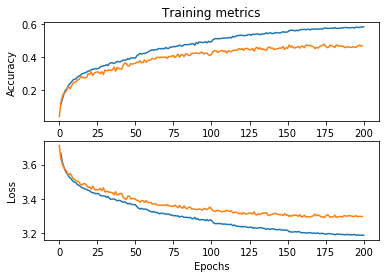

In [30]:
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,200)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

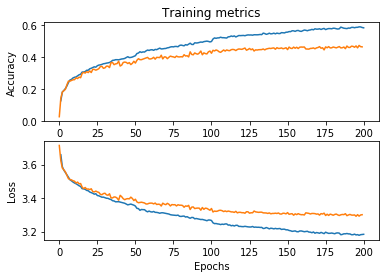

In [21]:
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,200)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

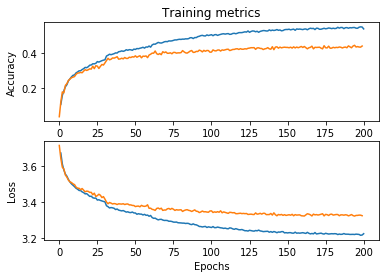

In [19]:
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,200)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()